In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from IPython.core.display import display, HTML, Markdown
import matplotlib.pyplot as plt
%matplotlib inline
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')
#follow instructions here: https://altair-viz.github.io/getting_started/installation.html#installation-notebook

import sys
sys.path.insert(1, '../scripts/')
import eda_tools as et
import data_munging_tools as dmt
# import impute_eval as ie
# import model_fitting_tools as mft




## Load data

In [52]:
# `pd.read_html()`  requires packages: lxml, html5lib, beautifulsoup4
data_dict = (pd.read_html('../data/AttributeDescriptions.html')[0]
             .copy()
             .rename(columns=lambda x: x.lower().replace(" ", "_"))
             .assign(field_name=lambda x: x["field_name"].apply(lambda x: x.lower()))
             .set_index("field_name")
             .sort_index()
            )

In [53]:
display(Markdown("### Data Dict"))
data_dict.style.set_properties(subset=['description'], **{'width': '700px'})

### Data Dict

,category,description
field_name,,
api,Identifier,Globally unique identifier for the well
bakken_isopach_ft,Geology,Thickness of the oil producing Bakken formation at the latitude/longitude of the well
bh_lat,Location,Latitude of the 'bottom hole' (the end of the laterally drilled bore)
bh_lng,Location,Longitude of the 'bottom hole' (the end of the laterally drilled bore)
choke_size,nan,Diameter in inches of the mechanical flow limiter
countyname,Location,Name of the County where the well is located
currentoperator,nan,Name of the Company that operates the well
currentwellname,nan,"Name of the well; essentially free text, naming conventions vary by operator"
dfelev,nan,Drilling floor elevation


In [54]:
# Load the dataframes
test_df = pd.read_csv('../data/cleaned-input.test.tsv', sep='\t', low_memory=False)
train_df = pd.read_csv('../data/cleaned-input.training.tsv', sep='\t', low_memory=False)

In [55]:
inspect_df = (train_df.copy()
                      .rename(columns=str.lower)
                      .assign(api = lambda x: x["api"].str.strip("US"))
                      .set_index("api")
                      .sort_index(axis=1)
                      .assign(length=lambda x: dmt.haversine_distance(x["surface_lat"], x["surface_lng"], x["bh_lat"], x["bh_lng"]))
                      .assign(prop_per_ft=lambda x: x["total_lbs_proppant"] / x["length"])
                      .assign(fluid_per_ft=lambda x: x["total_volume_bbls"]/ x["length"])
                      .assign(stage_spacing=lambda x: x["total_num_stages"] / x["length"])
             )

# Categorical Columns

In [56]:
cat_df = inspect_df.copy().select_dtypes("O")

In [57]:
for col in cat_df.columns:
    nunique = cat_df[col].nunique()
    
    if nunique <= 20:
        display(Markdown(f"### {col}: {nunique}"))
        display(cat_df[col].value_counts().to_frame())
    else:
        display(Markdown(f"### {col}: **{nunique}**"))

### choke_size: **217**

### countyname: 15

,countyname
MCKENZIE,1796
MOUNTRAIL,1605
WILLIAMS,1081
DUNN,1078
DIVIDE,432
BURKE,182
STARK,133
BILLINGS,101
BOTTINEAU,81
MCLEAN,25


### currentoperator: **56**

### currentwellname: **6529**

### fieldname: **333**

### footages: **6120**

### leasename: **3231**

### leasenumber: **4523**

### originaloperator: **99**

### originalwellname: **6527**

### producedpools: 13

,producedpools
BAKKEN,6310
SANISH,82
SPEARFISH,72
BAKKEN/THREE FORKS,30
SPEARFISH/MADISON,8
MADISON,6
TYLER,2
LODGEPOLE,2
THREE FORKS,2
BIRDBEAR,1


### qq: **43**

### range: **24**

### spud_date: **2133**

### stimulated_formation: 14

,stimulated_formation
bakken,3987
three forks,1617
spearfish,85
pronghorn,7
madison,4
tyler,3
red river,2
"bakken,three forks",2
bakken/three forks,1
bluell,1


### township: **30**

### type_treatment: 9

,type_treatment
sand frac,4618
other,622
fracture,158
"other,sand frac",3
acid,2
"acid,gelled acid",1
"hydrochloric acid,sand frac",1
"fracture,sand frac",1
hydrochloric acid,1


### well_status_date: **2151**

### wellbore: 3

,wellbore
HORIZONTAL,6519
HORIZONTAL RE-ENTRY,6
DIRECTIONAL,4


### wellstatus: 8

,wellstatus
A,6248
IA,250
DRL,7
PA,7
TA,7
AB,5
DRY,3
PNC,2


### welltype: 1

,welltype
OG,6529


# Space and time

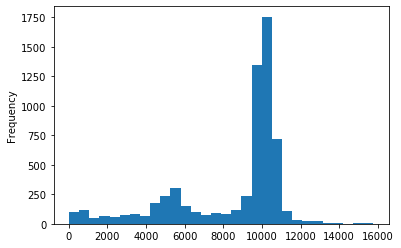

In [58]:
inspect_df.length.plot.hist(bins=30)

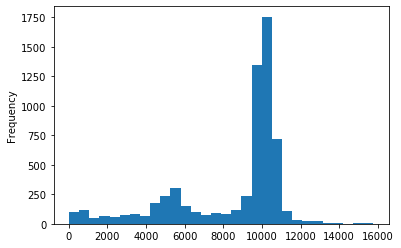

In [59]:
inspect_df.length.plot.hist(bins=30)

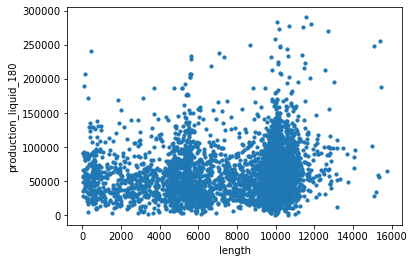

In [60]:
inspect_df.plot.scatter(x="length", y="production_liquid_180", s=10)

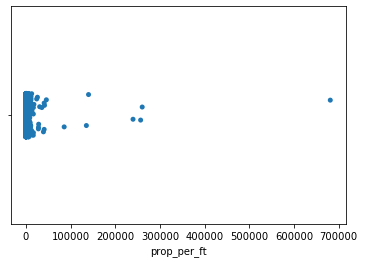

In [61]:
sns.stripplot(data=inspect_df, x="prop_per_ft")

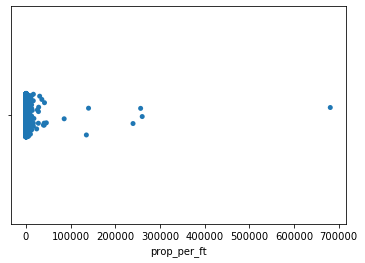

In [62]:
sns.stripplot(data=inspect_df, x="prop_per_ft")

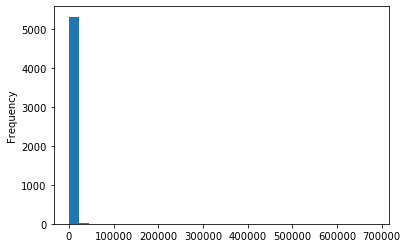

In [63]:
inspect_df.prop_per_ft.plot.hist(bins=30)

In [64]:
inspect_df.shape[0]

6529

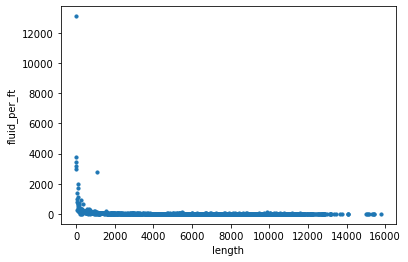

In [65]:
inspect_df.plot.scatter(x="length", y="fluid_per_ft", s=10)

In [66]:
inspect_df.query("length < 2000").filter(["length"]).shape[0]

316

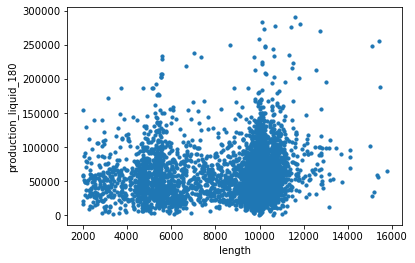

In [67]:
inspect_df.query("length > 2000").plot.scatter(x="length", y="production_liquid_180", s=10)

In [68]:
inspect_df.filter(regex="bbls").head()

,total_volume_bbls
api,
33105034550000,90232.0
33053034020000,69347.0
33061026020000,46463.0
33089007540000,55196.0
33061021060000,NaN


In [69]:
print(inspect_df.query("length > 5000").shape[0],
inspect_df.query("fluid_per_ft < 100").shape[0])

5262 5103


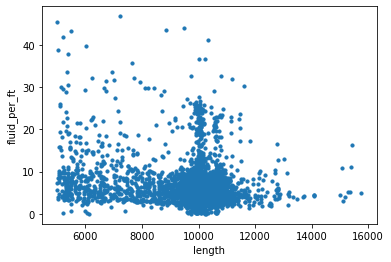

In [22]:
inspect_df.query("length > 5000 & fluid_per_ft < 100").plot.scatter(x="length", y="fluid_per_ft", s=10)

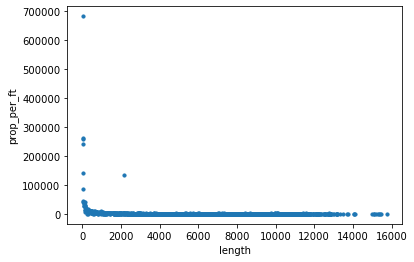

In [23]:
inspect_df.plot.scatter(x="length", y="prop_per_ft", s=10)

# Choke Size

https://gohaynesvilleshale.com/group/sanaugustine/forum/topics/what-is-the-choke-and-how-does-it-effect-production-rates

In [229]:
def parse_choke_size(x):
    replace_dict = {"a": "6", "s": "5", "i": "1", "0pen": "1", "b": "6", "g": "9"}
    
    if x == "na":
        # presumably it has no choke, ie it is open, therefore 1
        return 1
    
    if type(x) == float and np.isnan(x):
        return x
    
    if type(x) != str:
        print(x, type(x))
        return np.nan
    
    if "/" not in x:
        return np.nan
    
    for k, v in replace_dict.items():
        x = x.replace(k, v)
        
    x = x.strip("'").strip("_").strip(" ").strip("'")
    
    fraction = x.split("/")
    if len(fraction) != 2:
        return np.nan
    num, denom = fraction[0], fraction[1]
    
    
    try:
        num = int(num)
        denom = int(denom)
        
    except:
#         print(f"couldnt_convert {num} / {denom}")
        return np.nan
    
    
    if num == denom:
        # 64/64 would be open ratio, but assume it is open
        return 1
    
    elif num > denom:
        # something went wrong. cant be more open than open.
        return np.nan
    
    else:
        decimal = num / denom
        return decimal
    

In [230]:
inspect_df["choke_size_new"] = inspect_df.choke_size.apply(lambda x: parse_choke_size(x))

In [231]:
inspect_df.choke_size_new.isnull().sum() / inspect_df.shape[0]

0.20401286567621382

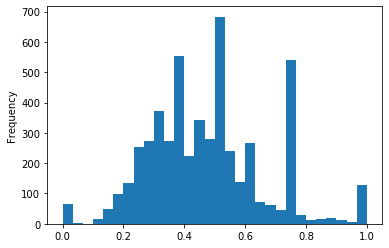

In [232]:
inspect_df.choke_size_new.plot.hist(bins=30)

### Plots

In [28]:
cat_df = (inspect_df.copy()
                  .select_dtypes("O")
                  .pipe(dmt.drop_hi_lo_card)
                  .drop(["choke_size"], axis=1)
                  .pipe(dmt.reduce_cardinality)
         )

Shape before cardinality removal: (6529, 21)
Shape after cardinality removal: (6529, 13)


In [29]:
cat_cols = cat_df.columns

In [30]:
cat_df = cat_df.join(inspect_df.filter(["production_liquid_180"]))

In [31]:
cat_df.head()

,countyname,currentoperator,fieldname,originaloperator,producedpools,qq,range,stimulated_formation,township,type_treatment,wellbore,wellstatus,production_liquid_180
api,,,,,,,,,,,,,
33105034550000,WILLIAMS,WHITING OIL AND GAS CORPORATION,OTHER,OTHER,BAKKEN,SESE,OTHER,bakken,154 N,sand frac,HORIZONTAL,A,48302.0
33053034020000,MCKENZIE,"HESS BAKKEN INVESTMENTS II, LLC",OTHER,OTHER,BAKKEN,OTHER,OTHER,bakken,151 N,sand frac,HORIZONTAL,A,58729.0
33061026020000,MOUNTRAIL,OTHER,OTHER,OTHER,BAKKEN,NENW,OTHER,three forks,155 N,fracture,HORIZONTAL,A,17221.0
33089007540000,OTHER,WHITING OIL AND GAS CORPORATION,OTHER,WHITING OIL AND GAS CORPORATION,BAKKEN,NENW,OTHER,bakken,OTHER,sand frac,HORIZONTAL,A,44904.0
33061021060000,MOUNTRAIL,OTHER,OTHER,OTHER,BAKKEN,OTHER,OTHER,bakken,155 N,NaN,HORIZONTAL,A,104497.0


In [32]:
def bar_plots(df, cat_cols, target_col):
    """
    Pass a dataframe, a list of columns that are categorical features, and a
    continuous target variable.

    Returns a two barcharts for each categorical feature:
     1. a count of the number of unique values in that column
     2. the median score of the target column fo each unique value in that column.
     """

    plt.rcParams.update({'font.size': 14})
    
    for col in cat_cols:
        fig, ax = plt.subplots(1, 2, figsize=(16, 5))
        vc = df[col].value_counts().sort_index()
        gb = df.groupby(col).median()[target_col].sort_index()
        
        ax[0].bar(range(vc.size),vc)
        ax[0].set_xticks(range(vc.size))
        ax[0].set_xticklabels(vc.index, fontsize=9, rotation=90)
        ax[0].set_title("Value counts of {}".format(col))
        
        ax[1].bar(range(gb.size),gb)
        ax[1].set_xticks(range(gb.size))
        ax[1].set_xticklabels(gb.index, fontsize=9, rotation=90)
        ax[1].set_title("Median {} by {}".format(target_col, col))


    plt.tight_layout()
    plt.show()

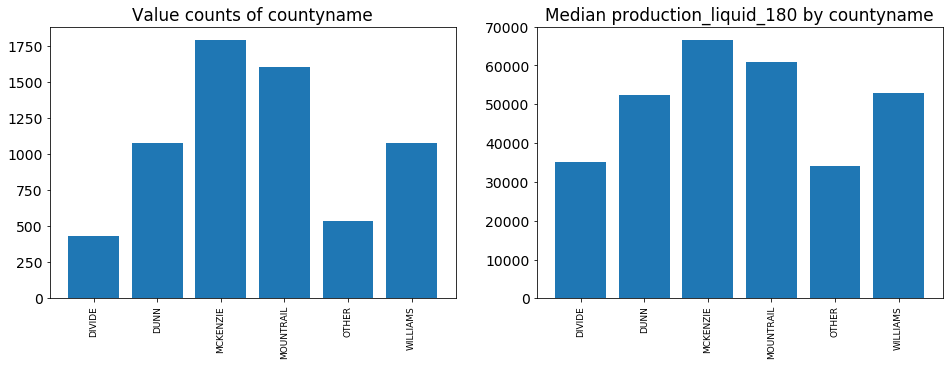

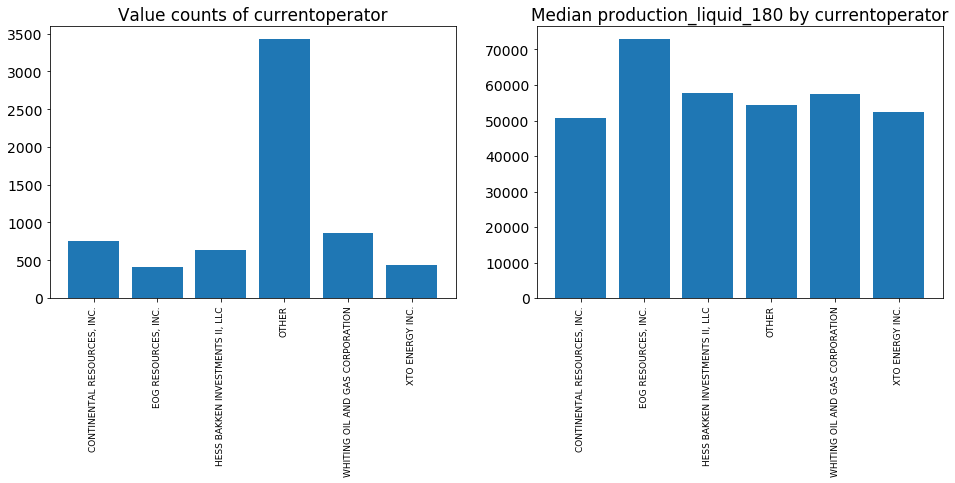

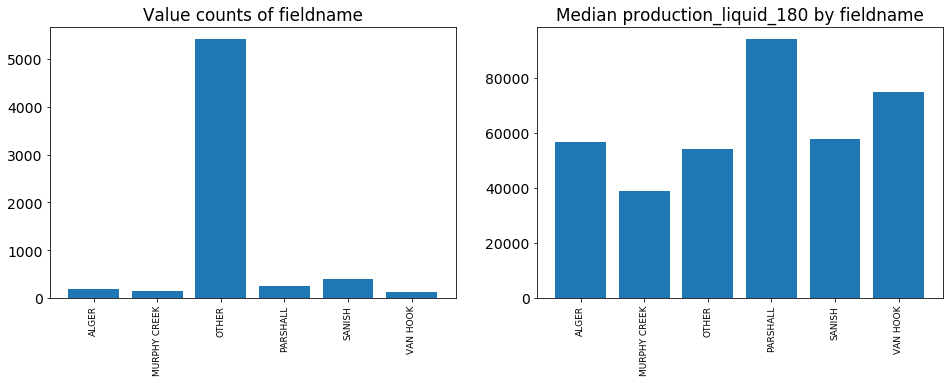

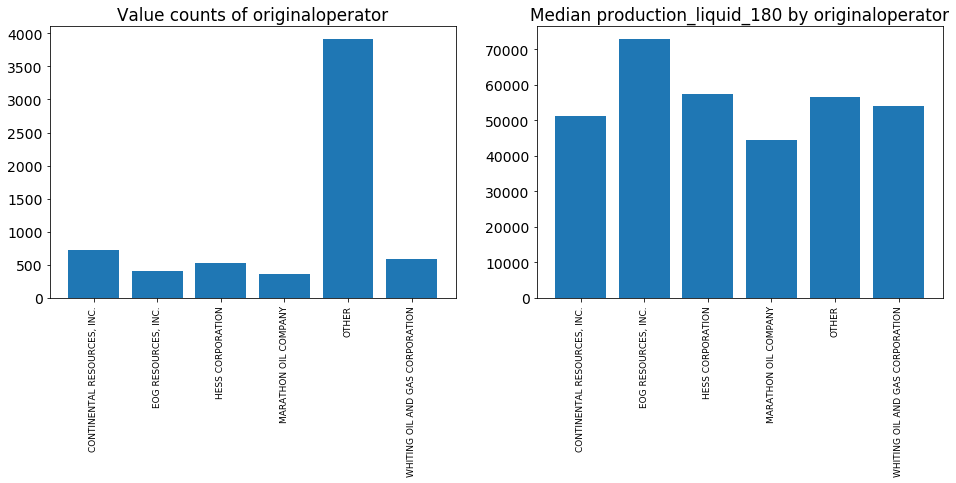

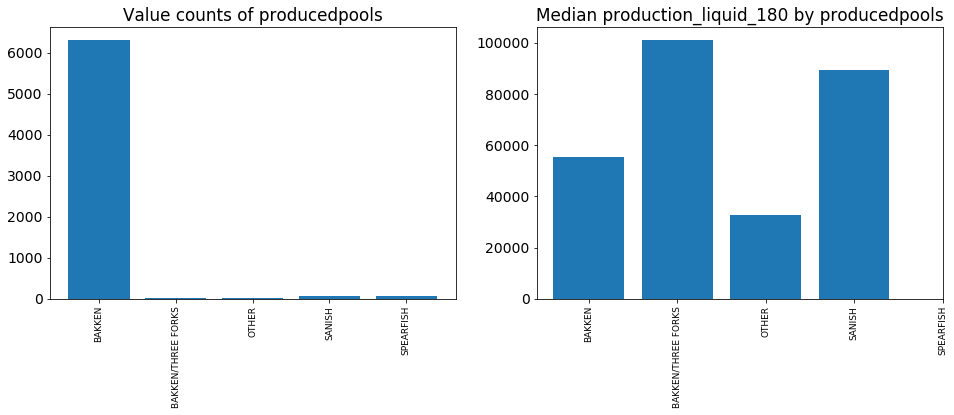

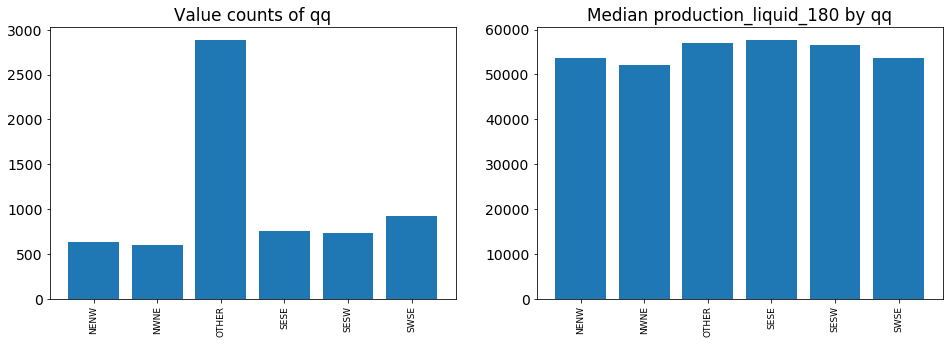

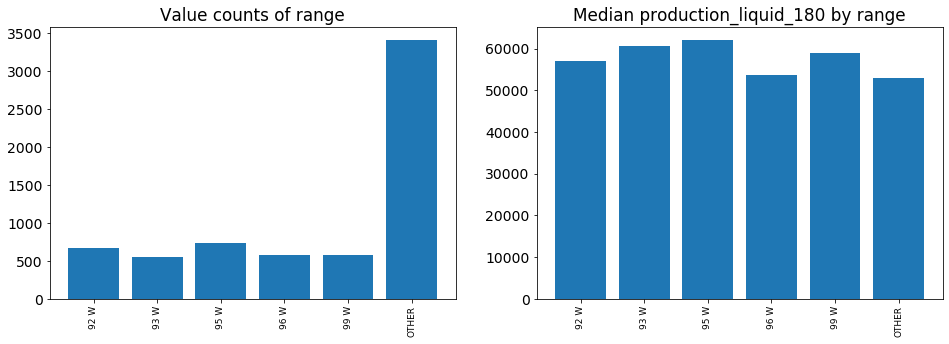

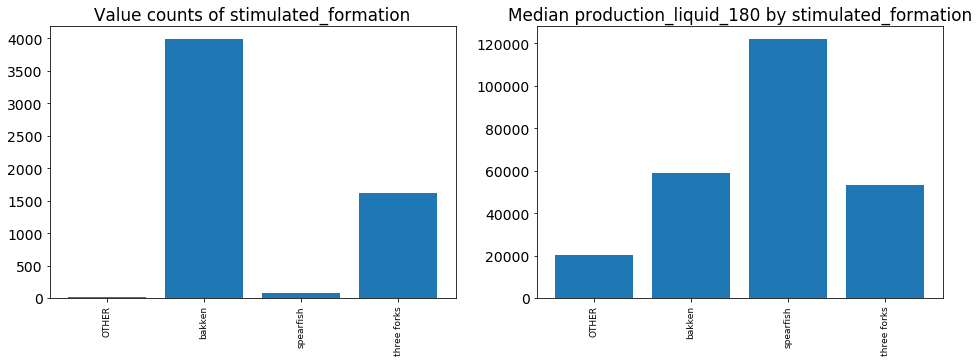

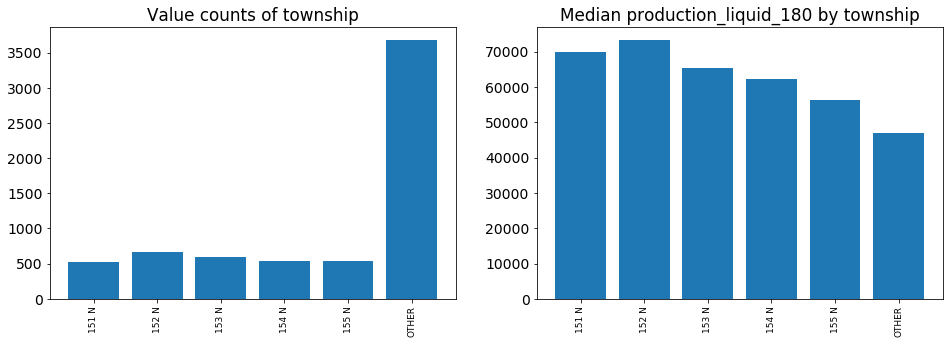

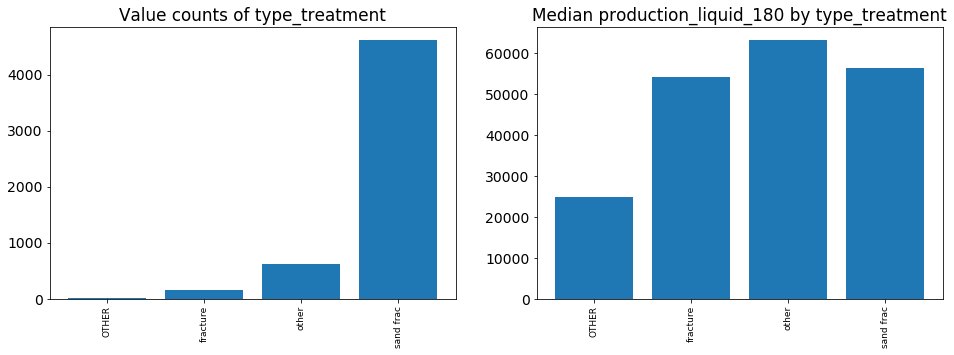

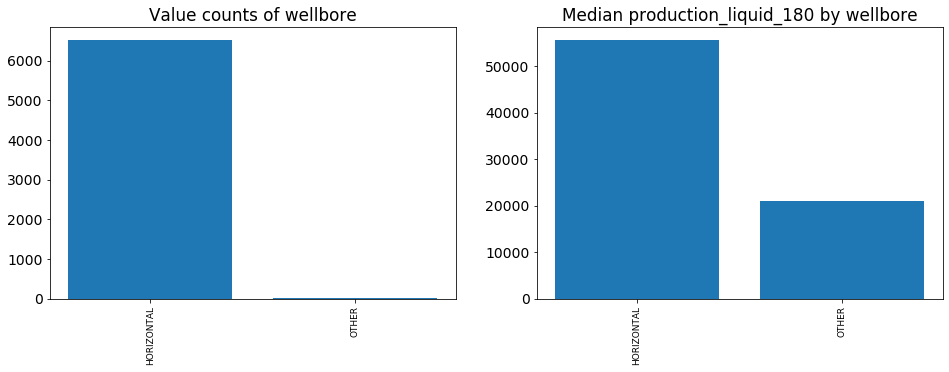

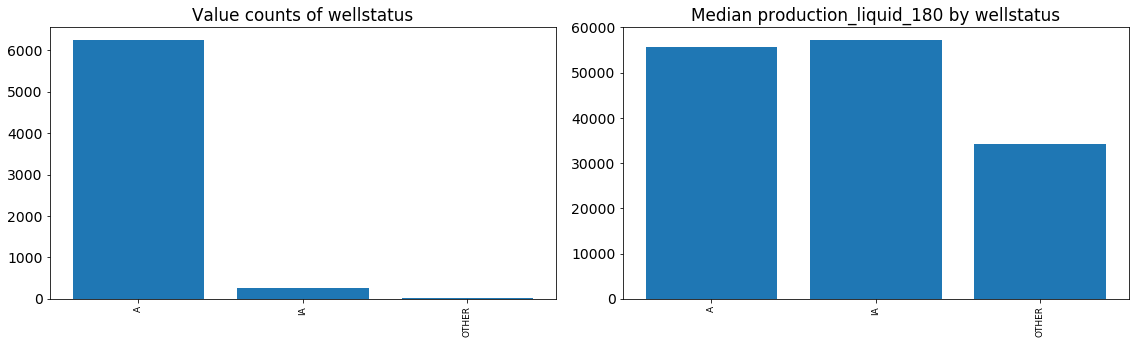

In [33]:
bar_plots(cat_df, cat_cols=cat_cols, target_col="production_liquid_180")

# Continuous Features

In [326]:
foi = sorted([
'total_lbs_proppant',
'total_num_stages', 
'total_volume_bbls',
'length',
'tvd',
'prop_per_ft',
'fluid_per_ft', 
'stage_spacing', 
'choke_size_new',
'mean_tvd',
'bakken_isopach_ft'
])

total_cols = sorted([
'total_lbs_proppant',
'total_num_stages', 
'total_volume_bbls',
'length',
])

normd_cols = sorted([
'prop_per_ft',
'fluid_per_ft', 
'stage_spacing'
])

other = sorted([
'mean_tvd',
'bakken_isopach_ft' 
])

In [327]:
cont_df = (inspect_df.copy()
                   .select_dtypes("number")
                   .filter(foi)
                   .sort_index(axis=1)
          )

In [328]:
cont_df.shape

(6529, 11)

In [329]:
cont_df.columns

Index(['bakken_isopach_ft', 'choke_size_new', 'fluid_per_ft', 'length',
       'mean_tvd', 'prop_per_ft', 'stage_spacing', 'total_lbs_proppant',
       'total_num_stages', 'total_volume_bbls', 'tvd'],
      dtype='object')

## Removing outliers

#### bakken_isopach_ft

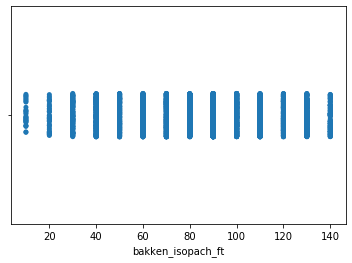

#### choke_size_new

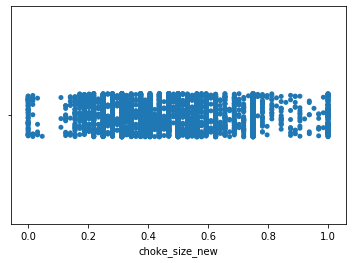

#### fluid_per_ft

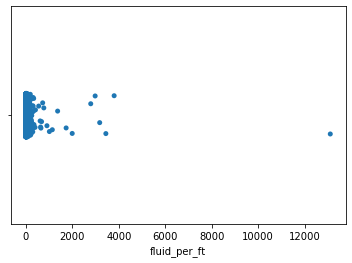

#### length

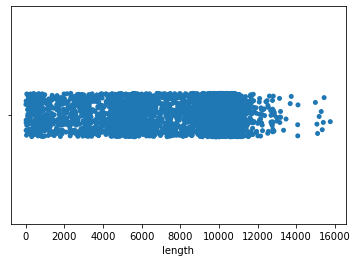

#### mean_tvd

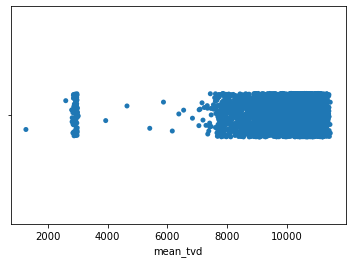

#### prop_per_ft

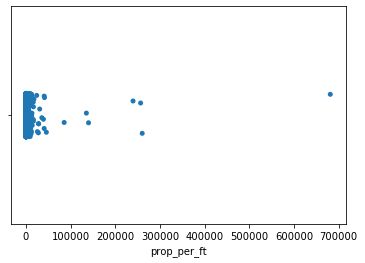

#### stage_spacing

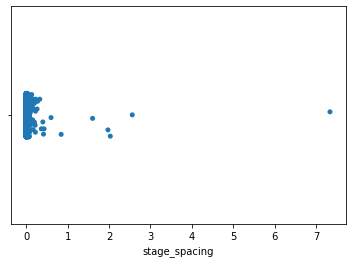

#### total_lbs_proppant

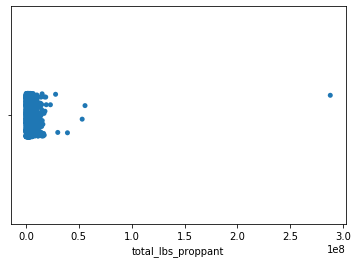

#### total_num_stages

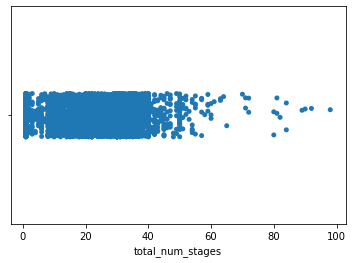

#### total_volume_bbls

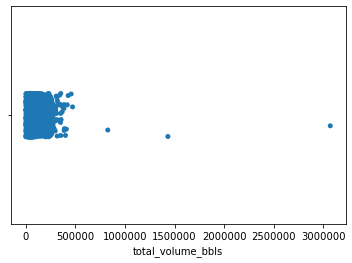

#### tvd

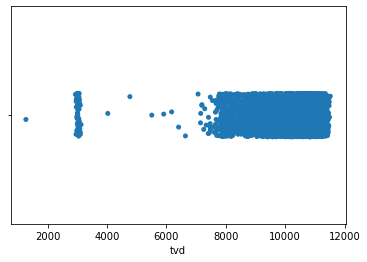

In [330]:
for feature in foi:
    display(Markdown(f"#### {feature}"))
    sns.stripplot(data=cont_df, x=feature)
    plt.show()

In [359]:
thresholds_dict = {"total_lbs_proppant": {"min": 0, "max": 20000000.0},
 "total_volume_bbls": {"min": 0, "max": 500000.0},
 "total_num_stages": {"min": 5, "max": float("inf")},
 "length": {"min": 2000, "max": float("inf")}
}

In [365]:
def remove_outiers(df, lims_dict):
    df = df.copy()
    for feature, limits in lims_dict.items():
        print(feature)
        up_lim = limits["max"]
        lo_lim = limits["min"]
        
        max_mask = df[feature] > up_lim
        min_mask = df[feature] < lo_lim
        
        both_mask = min_mask | max_mask
        
#         display(df.loc[max_mask])
        
        df.loc[both_mask, feature] = np.nan 
    return df

In [366]:
clean_df = (cont_df.copy()
                   .pipe(remove_outiers, thresholds_dict)
                    .assign(prop_per_ft=lambda x: x["total_lbs_proppant"] / x["length"],
                            fluid_per_ft=lambda x: x["total_volume_bbls"]/ x["length"],
                            stage_spacing=lambda x: x["total_num_stages"] / x["length"]
                            )
           )

total_lbs_proppant
total_volume_bbls
total_num_stages
length


#### bakken_isopach_ft

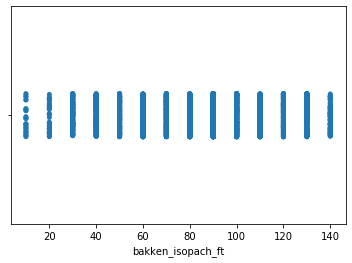

#### choke_size_new

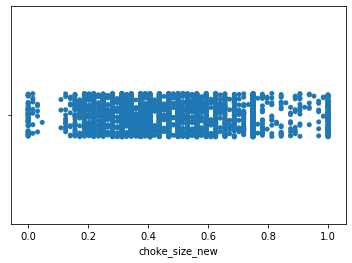

#### fluid_per_ft

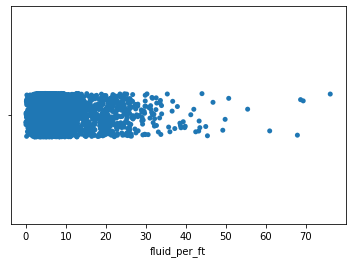

#### length

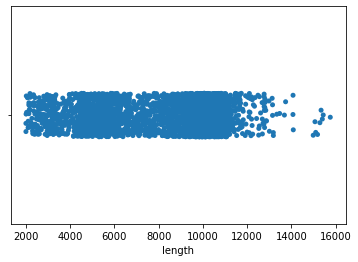

#### mean_tvd

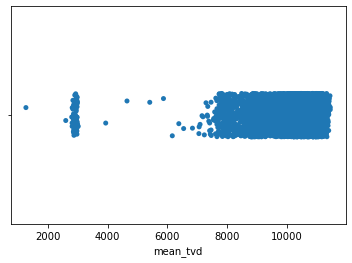

#### prop_per_ft

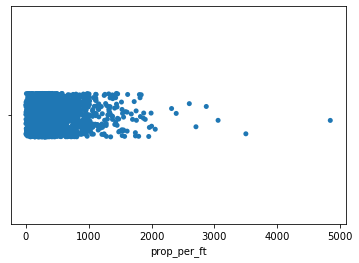

#### stage_spacing

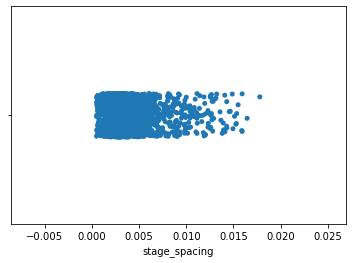

#### total_lbs_proppant

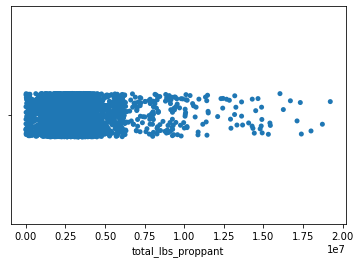

#### total_num_stages

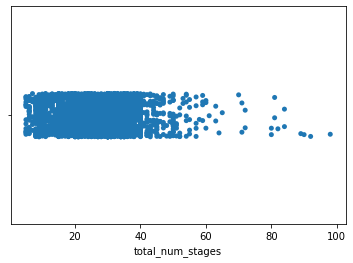

#### total_volume_bbls

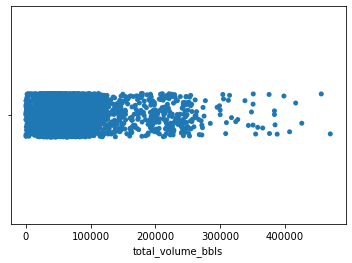

#### tvd

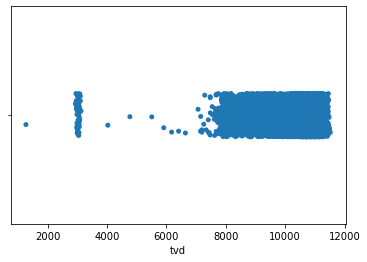

In [367]:
for feature in foi:
    display(Markdown(f"#### {feature}"))
    sns.stripplot(data=clean_df, x=feature)
    plt.show()

In [357]:
clean_df.sort_values("prop_per_ft", ascending=False).head(20)

,bakken_isopach_ft,choke_size_new,fluid_per_ft,length,mean_tvd,prop_per_ft,stage_spacing,total_lbs_proppant,total_num_stages,total_volume_bbls,tvd
api,,,,,,,,,,,
33053046340000,90.0,0.31250,122.970294,1065.834645,11174.032727,7561.179436,0.038468,8058967.0,41.0,131066.0,11360.73
33025024030000,90.0,0.53125,87.604561,1020.974243,10418.341250,4975.208760,0.019589,5079560.0,20.0,89442.0,10557.91
33061024880000,90.0,1.00000,60.936115,3716.482394,9351.827237,4846.017038,0.015875,18010137.0,59.0,226468.0,9426.41
33105031140000,80.0,0.65625,97.904241,1039.975376,11112.691936,3969.398790,0.033655,4128077.0,35.0,101818.0,11296.79
33105031760000,90.0,0.34375,191.039073,1566.103707,10749.039474,3858.598235,0.025541,6042965.0,40.0,299187.0,10844.63
33053051310000,50.0,NaN,76.480288,1013.450682,10692.225814,3776.494571,0.024668,3827291.0,25.0,77509.0,10865.38
33023010800000,110.0,0.68750,48.193706,1927.222623,8404.776341,3586.105164,0.025944,6911223.0,50.0,92880.0,8486.04
33053049620000,90.0,0.34375,50.693361,2300.340672,10805.302500,3502.011723,0.013911,8055820.0,32.0,116612.0,10879.24
33025015010000,80.0,NaN,47.833046,1328.872081,10171.932381,3404.790471,0.021823,4524531.0,29.0,63564.0,10270.58


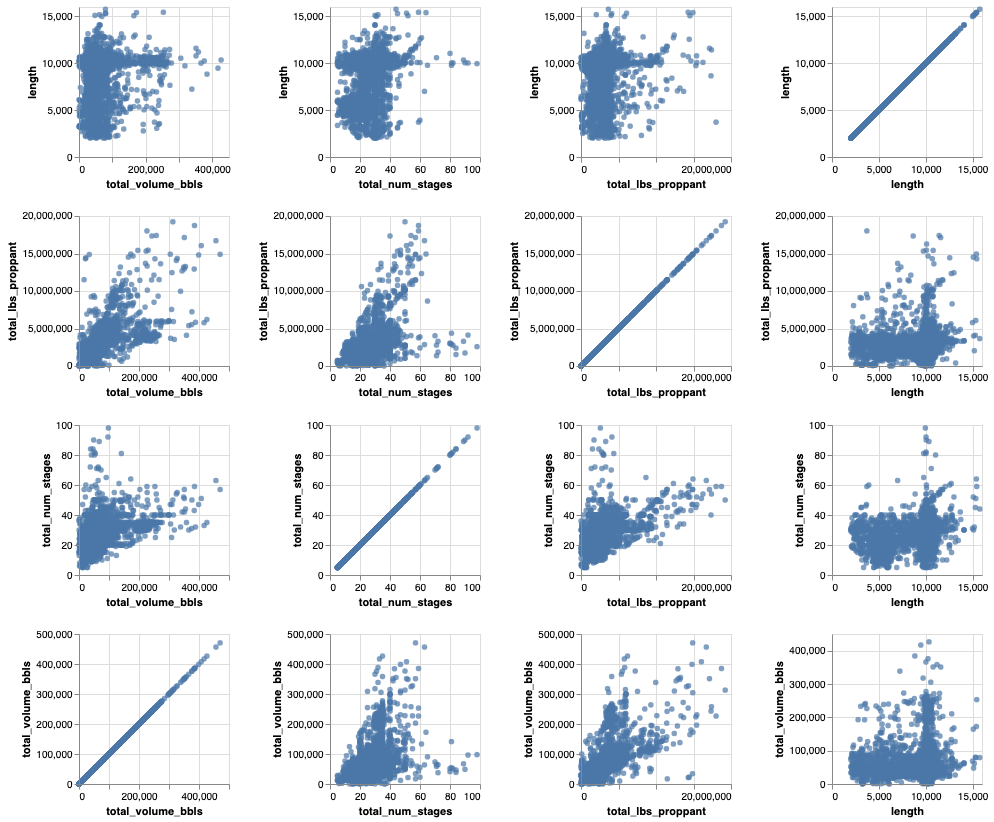

In [363]:
alt.Chart(clean_df[total_cols]).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
#     color='Origin:N'
).properties(
    width=150,
    height=150
).repeat(
    row=total_cols,
    column=total_cols[::-1]
)

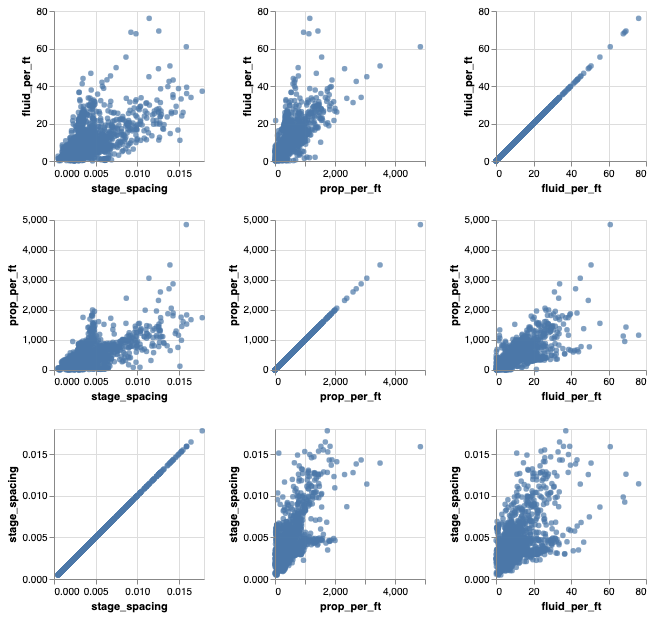

In [364]:
alt.Chart(clean_df).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
#     color='Origin:N'
).properties(
    width=150,
    height=150
).repeat(
    row=normd_cols,
    column=normd_cols[::-1]
)

## Correlation Matrix Heatmap